## Introduction

This notebook presents the exploratory data analysis (EDA) and visualization component of a project that aims to predict whether a customer will recommend a product based on their review. The dataset contains customer feedback from an e-commerce clothing retailer. The insights gained from this analysis will guide the development of a binary classification model to predict product recommendations.

## Load libraries and Inspect Data

We begin by loading the dataset and performing an initial inspection to understand the structure, column names, and types of data we are dealing with.

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df = pd.read_csv("../Data/Womens Clothing E-Commerce Reviews.csv") 

In [32]:
df.head()

,Index,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Index                    23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [34]:
df.describe()


,Index,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [35]:
print(df.isnull().sum())
df.dropna(inplace=True)

print("Number of duplicate rows:", df.duplicated().sum())

print(df['Rating'].value_counts())     

Index                         0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64
Number of duplicate rows: 0
Rating
5    10858
4     4289
3     2464
2     1360
1      691
Name: count, dtype: int64


## Clean data

This step includes removing duplicates, standardizing column names for ease of use, and stripping whitespace from text entrieg.

In [36]:
df = df.drop(columns=['Index'])
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.drop_duplicates(inplace=True)

## Handling Missing Values

We drop rows with missing values in essential columns such as 'review_text' and 'recommended_ind', which are critical for the prediction task. For less essential text fields like 'title', we impute missing values with empty strings to maintain consistency.

In [37]:
df = df.dropna(subset=['review_text', 'recommended_ind'])
df['title'] = df['title'].fillna('')

In [38]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Defining the target variable and features
X = df.drop('recommended_ind', axis=1)
y = df['recommended_ind']

X_train_eda, X_test, y_train_eda, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


df_train = pd.concat([X_train_eda, y_train_eda], axis=1).copy()


df_test = pd.concat([X_test, y_test], axis=1).copy()

print("Training size:", df_train.shape)
print("Test size:", df_test.shape)


Training size: (15729, 10)
Test size: (3933, 10)


In [39]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

# applied preprocessing to the review_text column
df_train['cleaned_review_text'] = df_train['review_text'].apply(preprocess_text)
df_test['cleaned_review_text'] = df_test['review_text'].apply(preprocess_text)

print(df_train[['review_text', 'cleaned_review_text']].head())

                                             review_text  \
13777  I absolutely love this dress! it's a great sum...   
531    Perfect little summer tunic that is very flatt...   
17767  I have never had a purchase go wrong at retail...   
9477   Beautiful white top. peplum never looged good ...   
17049  I bought this on a whim, and i love it. the co...   

                                     cleaned_review_text  
13777  absolutely love dress great summer dress thats...  
531    perfect little summer tunic flattering paired ...  
17767  never purchase go wrong retailer hesitant spen...  
9477   beautiful white top peplum never looged good f...  
17049  bought whim love color much brighter photo wou...  


# Analyze Distributions

### Distribution of Ratings

This plot shows how users rated the product, on a scale from 1 to 5. It provides insight into user satisfaction trends and overall sentiment.

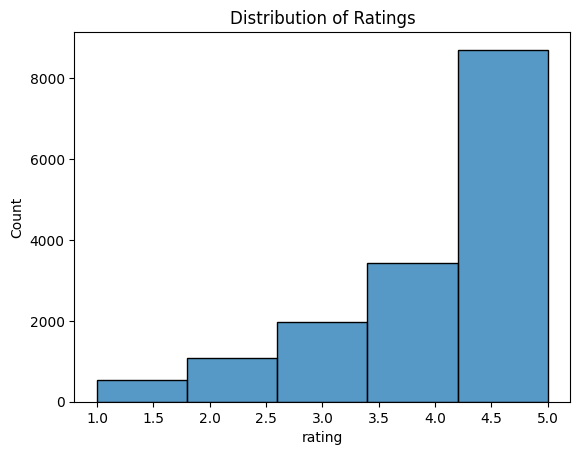

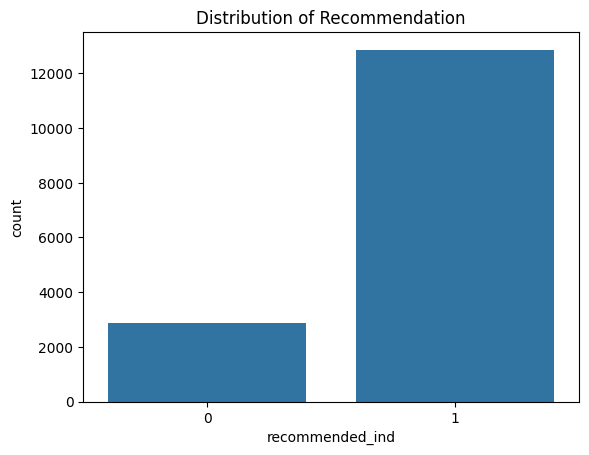

In [40]:

sns.histplot(df_train['rating'], bins=5)
plt.title('Distribution of Ratings')
plt.show()

sns.countplot(x='recommended_ind', data=df_train)
plt.title('Distribution of Recommendation')
plt.show()


 The distribution is heavily right-skewed, with the majority of ratings being 4 and 5.
- This suggests that most users are satisfied or very satisfied with the product.
- The low number of ratings below 3 could indicate either a generally well-received product or potential rating bias.

In [41]:
recommendation_counts_train = df_train['recommended_ind'].value_counts(normalize=True) * 100
print(recommendation_counts_train)

recommended_ind
1    81.817026
0    18.182974
Name: proportion, dtype: float64


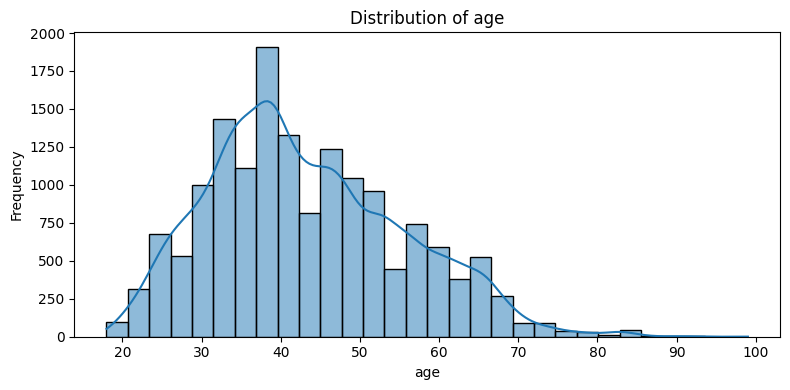

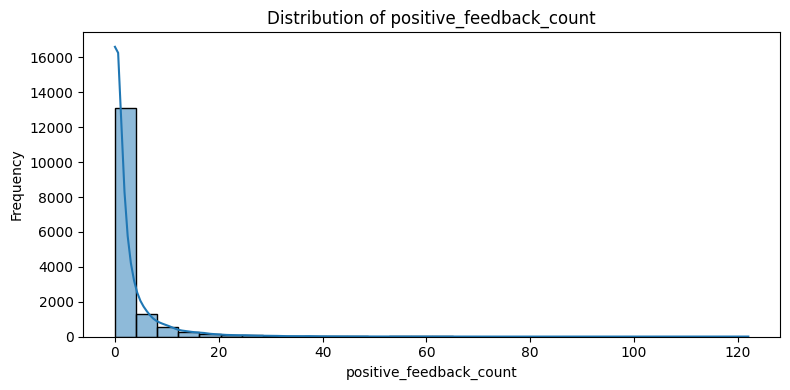

In [42]:
numeric_cols = ['age', 'positive_feedback_count']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_train[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


- The histogram and KDE line reveal that most reviewers fall between **30 and 50 years old**, with a clear peak around **40**. The distribution is slightly **right-skewed**, meaning there are fewer older customers, though some reviews come from users up to their 80s or 90s. So the brand's core audience is likely **middle-aged women**, which aligns with expectations for apparel products.


In [43]:
# Outlier analysis for 'positive_feedback_count'
Q1_pf_train = df_train['positive_feedback_count'].quantile(0.25)
Q3_pf_train = df_train['positive_feedback_count'].quantile(0.75)
IQR_pf_train = Q3_pf_train - Q1_pf_train
up_bound = Q3_pf_train + 1.5 * IQR_pf_train
lo_bound = Q1_pf_train - 1.5 * IQR_pf_train

print(f"\nOutlier analysis for 'positive_feedback_count' on df_train:")
print(f"Lower bound: {lo_bound}, Upper bound: {up_bound}")

df_train['positive_feedback_count_capped'] = df_train['positive_feedback_count'].clip(lo_bound, up_bound)
df_test['positive_feedback_count_capped'] = df_test['positive_feedback_count'].clip(lo_bound, up_bound) 


Outlier analysis for 'positive_feedback_count' on df_train:
Lower bound: -4.5, Upper bound: 7.5


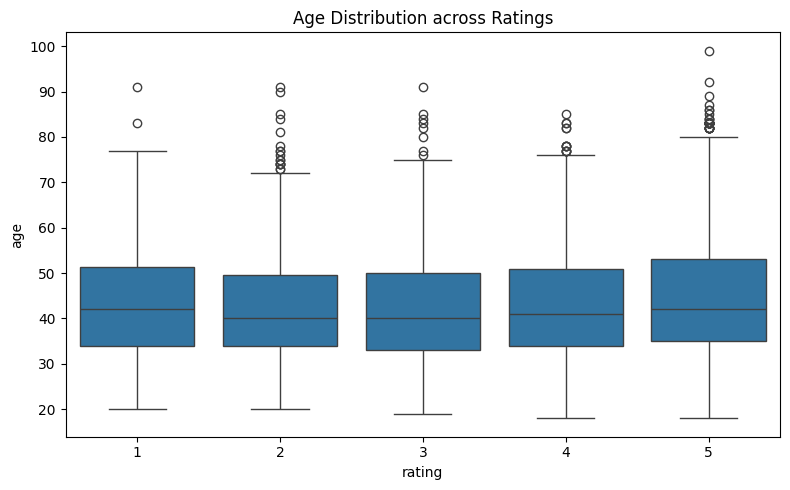

In [44]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='rating', y='age', data=df_train)
plt.title('Age Distribution across Ratings')
plt.tight_layout()
plt.show()


- The **median age** for each rating is fairly consistent, hovering around **40 years old**, regardless of how high or low the rating is.
- The **age spread** (interquartile range) is also quite similar across ratings, meaning people of various ages give both high and low ratings.
- There’s a slight upward trend in the median age as ratings increase — suggesting **older reviewers may be slightly more generous** or satisfied.
- **Outliers** are present in all categories, especially in the older age groups (above 70), indicating that a small number of older individuals provide both high and low ratings.
- There’s **no strong age bias** toward any specific rating: younger and older customers are present across all levels of satisfaction.

In [45]:
print("Percentage of customers above 80 years old:")
df_train[df_train['age'] > 80].shape[0]*100/df_train.shape[0]

Percentage of customers above 80 years old:


0.40053404539385845

In [46]:
df_train = df_train[df_train['age'] <= 80]
df_test = df_test[df_test['age'] <= 80]

## Explore feature relationships

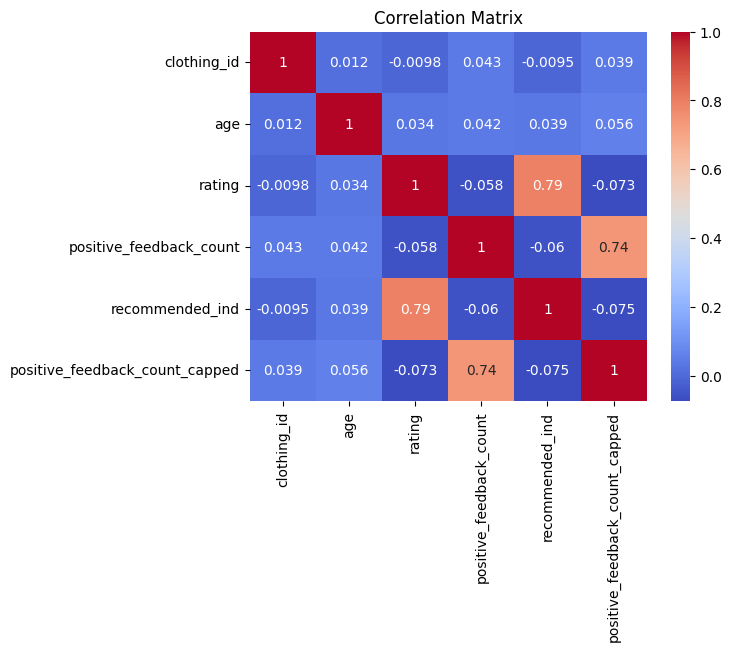

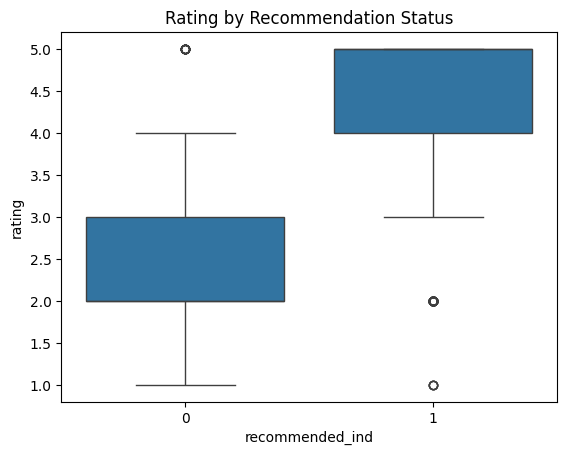

In [47]:
numeric_df_train = df_train.select_dtypes(include=['number']).dropna()

corr = numeric_df_train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

sns.boxplot(x='recommended_ind', y='rating', data=df_train)
plt.title('Rating by Recommendation Status')
plt.show()


- Users who recommended tend to give significantly higher ratings compared to those who did not recommend.
- The rating distribution for the recommended group is more skewed toward the high end (4 and 5).

In [48]:
df_train = df_train[~(
    ((df_train['recommended_ind'] == 1) & (df_train['rating'].isin([1, 2]))) |
    ((df_train['recommended_ind'] == 0) & (df_train['rating'].isin([4, 5])))
)]

df_test = df_test[~(
    ((df_test['recommended_ind'] == 1) & (df_test['rating'].isin([1, 2]))) |
    ((df_test['recommended_ind'] == 0) & (df_test['rating'].isin([4, 5])))
)]



## Exploratory Data Analysis (EDA)

We conduct statistical analysis and visualizations to understand key characteristics of the data. This includes:

- Distribution of the target variable (`recommended_ind`)
- Relationship between age and recommendations
- Frequency of feedback across product categories
- Word clouds to visualize common themes in positive and negative reviews

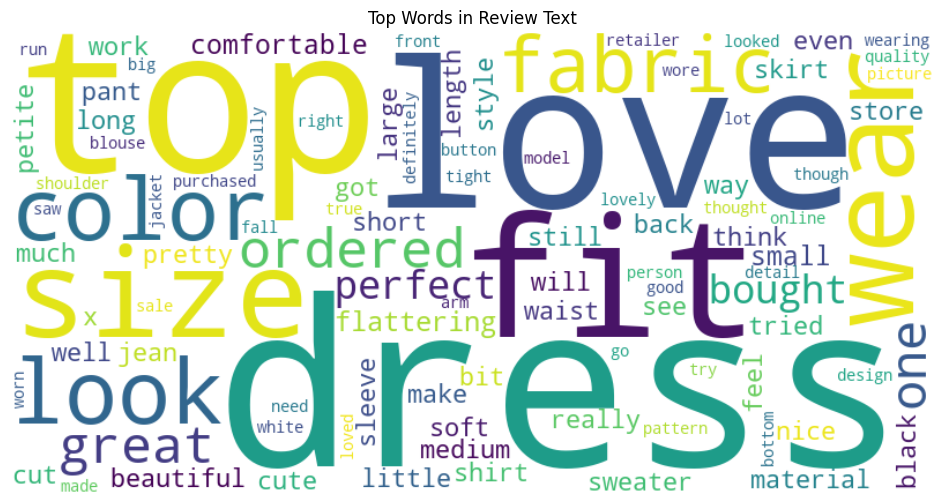

In [49]:
# remove missing values
text_data = df_train['review_text'].dropna()

combined_text = " ".join(text_data)

# Tạo Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(combined_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Top Words in Review Text")
plt.show()


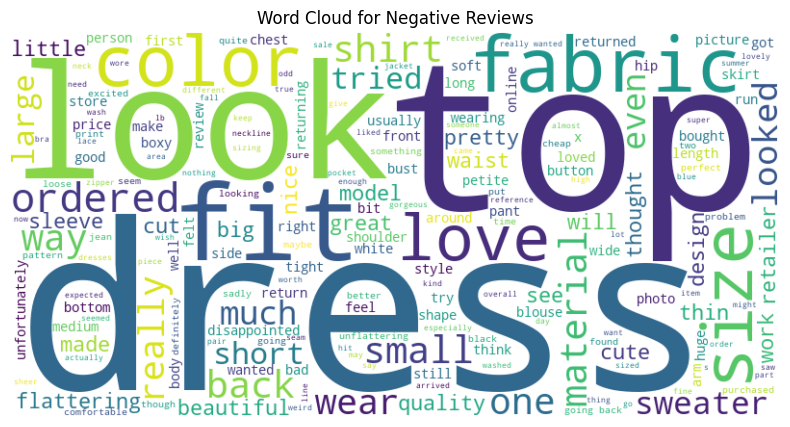

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter negative reviews
negative_reviews = df_train[df_train['recommended_ind'] == 0]['review_text'].dropna().str.cat(sep=' ')

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


- Positive reviews: Customers love the dresses and tops for their attractive design, soft fabric, good fit, and comfort. Many are satisfied and reorder.
- Negative reviews: Some customers complain about small sizing, tight fit, or thin fabric, leading to returns.

In [51]:
for col in ['division_name', 'department_name', 'class_name']:
    rec_rate = df_train.groupby(col)['recommended_ind'].mean().sort_values(ascending=False)
    print(f'Recommendation rate by {col}:')
    print(rec_rate)
    print('-' * 40)

Recommendation rate by division_name:
division_name
Initmates         0.847648
General Petite    0.828374
General           0.820103
Name: recommended_ind, dtype: float64
----------------------------------------
Recommendation rate by department_name:
department_name
Bottoms     0.861417
Jackets     0.851095
Intimate    0.847729
Tops        0.812701
Dresses     0.812664
Trend       0.770115
Name: recommended_ind, dtype: float64
----------------------------------------
Recommendation rate by class_name:
class_name
Chemises          1.000000
Casual bottoms    1.000000
Layering          0.903614
Jeans             0.879690
Legwear           0.864865
Lounge            0.863043
Jackets           0.862579
Skirts            0.859400
Intimates         0.857143
Pants             0.852814
Fine gauge        0.850829
Sleep             0.841727
Shorts            0.837321
Outerwear         0.825472
Dresses           0.812664
Blouses           0.812136
Knits             0.809293
Sweaters          0.79

- Intimates division and Bottoms department have the highest recommendation rates, both above 84%.
- Some classes like Chemises and Casual bottoms show a perfect 100% recommendation rate, likely due to small sample sizes or exceptional feedback.
- Trend category consistently has the lowest recommendation rate (~75.7%), indicating potential areas for improvement.

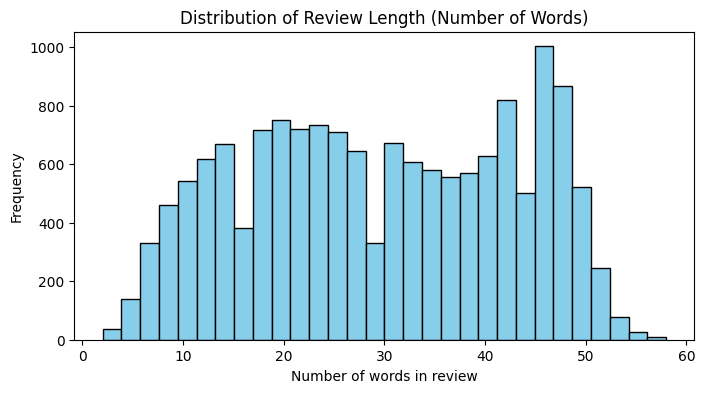

In [52]:
df_train['review_length'] = df_train['cleaned_review_text'].apply(lambda x: len(str(x).split()))
df_test['review_length'] = df_test['cleaned_review_text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,4))
plt.hist(df_train['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Length (Number of Words)')
plt.xlabel('Number of words in review')
plt.ylabel('Frequency')
plt.show()


The highest frequency of reviews falls in the range of approximately 45 to 50 words, indicating that most reviewers tend to write relatively longer reviews in that range.

### One-Hot Encoding for Categorical Variables

To use categorical features in machine learning models, we convert them into binary format using one-hot encoding. This step ensures that our model can interpret and learn from features such as 'division_name', 'department_name', and 'class_name'.

In [53]:
categorical_cols = ['division_name', 'department_name', 'class_name']


df_train = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)

train_cols = df_train.columns
test_cols = df_test.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    if c != 'recommended_ind':
         df_test[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    if c != 'recommended_ind':
        df_train[c] = 0

df_train_X = df_train.drop('recommended_ind', axis=1)

### TF-IDF Vectorization

We apply TF-IDF to the review text to convert unstructured text data into numerical form. This method helps highlight the most relevant words in customer feedback for the classification task.

In [54]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_tfidf_train = tfidf.fit_transform(df_train_X['cleaned_review_text'])
X_tfidf_test = tfidf.transform(df_test['cleaned_review_text'])


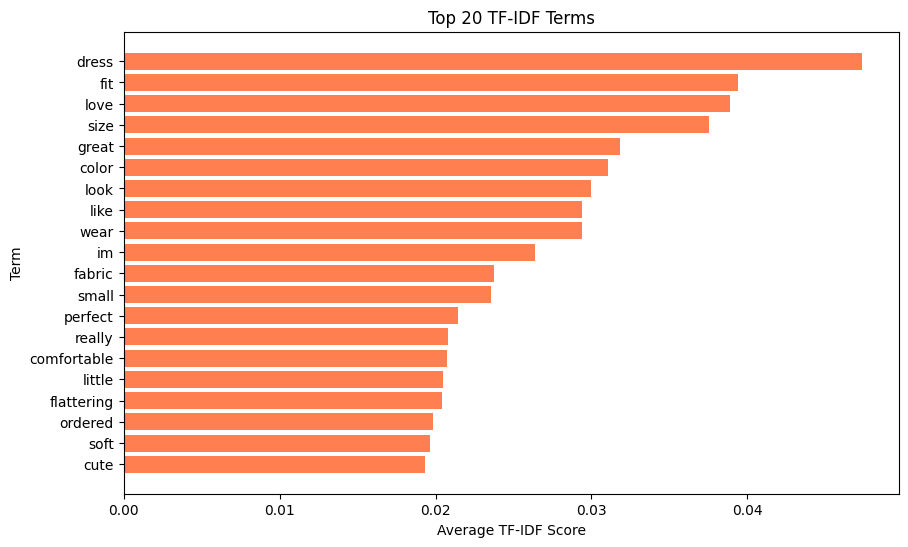

In [55]:
import numpy as np

tfidf_means = np.asarray(X_tfidf_train.mean(axis=0)).ravel()
terms = tfidf.get_feature_names_out()


tfidf_df = pd.DataFrame({'term': terms, 'tfidf': tfidf_means})

# top 20 TF-IDF terms
top_tfidf = tfidf_df.sort_values(by='tfidf', ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top_tfidf['term'][::-1], top_tfidf['tfidf'][::-1], color='coral')
plt.title('Top 20 TF-IDF Terms')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Term')
plt.show()

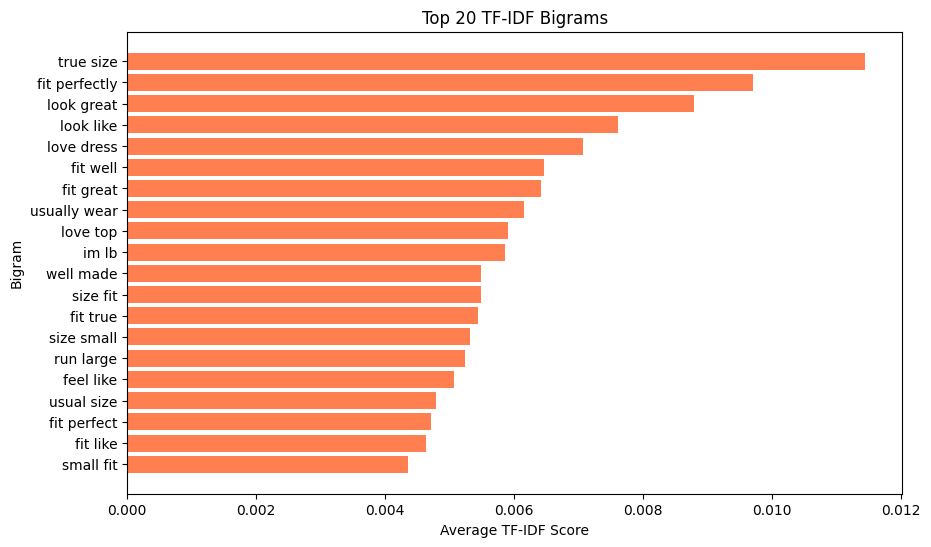

In [56]:
# bigrams
tfidf2 = TfidfVectorizer(ngram_range=(2, 2), max_features=5000)
X_tfidf2 = tfidf2.fit_transform(df_train_X['cleaned_review_text'])

tfidf2_means = np.asarray(X_tfidf2.mean(axis=0)).ravel()
terms2 = tfidf2.get_feature_names_out()

tfidf_df2 = pd.DataFrame({'term': terms2, 'tfidf': tfidf2_means})


top_tfidf2 = tfidf_df2.sort_values(by='tfidf', ascending=False).head(20)

plt.figure(figsize=(10,6))
plt.barh(top_tfidf2['term'][::-1], top_tfidf2['tfidf'][::-1], color='coral')
plt.title('Top 20 TF-IDF Bigrams')
plt.xlabel('Average TF-IDF Score')
plt.ylabel('Bigram')
plt.show()

- Customers focus heavily on size and fit, with phrases like "true size," "fit perfectly," and "runs large," highlighting the importance of choosing the right size.
- Feedback is predominantly positive regarding quality and style, with bigrams such as "love dress," "highly recommend," and "soft comfortable" reflecting satisfaction with the product’s look, comfort, and fabric.


## Sentiment Analysis

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

df_train['sentiment_score'] = df_train['cleaned_review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_test['sentiment_score'] = df_test['cleaned_review_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

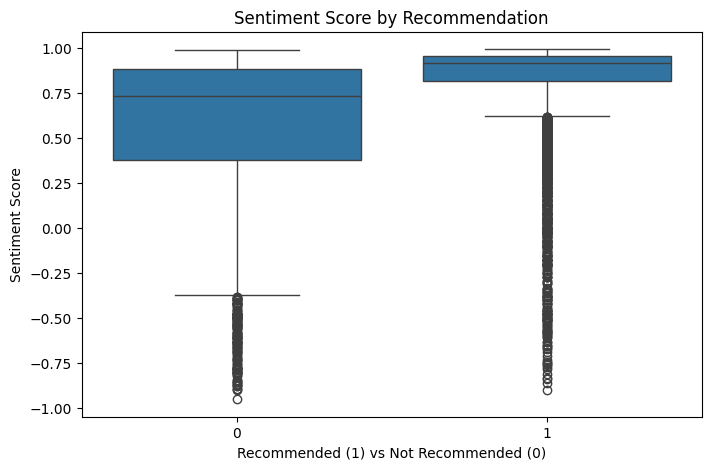

In [58]:
plt.figure(figsize=(8,5))
sns.boxplot(x='recommended_ind', y='sentiment_score', data=df_train)
plt.title('Sentiment Score by Recommendation')
plt.xlabel('Recommended (1) vs Not Recommended (0)')
plt.ylabel('Sentiment Score')
plt.show()


- The recommended group has a higher average and more concentrated sentiment score compared to the not recommended group. However, the recommended group still contains many low sentiment outliers, which may be due to some individual negative reviews. The not recommended group shows a wider dispersion of sentiment scores, possibly because of more diverse evaluations or a higher number of neutral/negative users.

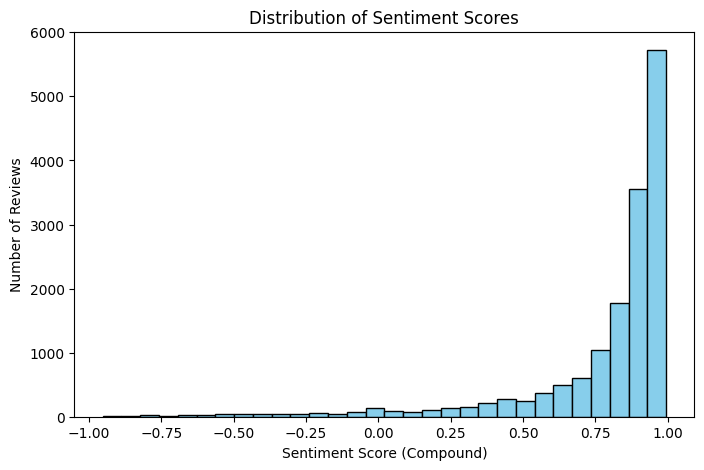

In [59]:
plt.figure(figsize=(8,5))
plt.hist(df_train['sentiment_score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score (Compound)')
plt.ylabel('Number of Reviews')
plt.show()


- Most sentiment scores are between 0.7 and 1, indicating that the majority of reviews have positive or very positive sentiment.
- A smaller portion of reviews have negative sentiment scores (below 0), but these are much fewer in number compared to positive ones.

In [60]:
df_train.to_csv('../Data/FE_reviews_train.csv', index=False)
df_test.to_csv('../Data/FE_reviews_test.csv', index=False)